In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb 
import xgboost as xgb 
from hyperopt.pyll.base import scope

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score, make_scorer
sns.set() # use seaborn plotting style

from IPython.core.display import display, HTML
import random

In [190]:
DATA_PATH = 'data/Task_data.xlsx'
TARGET_COLUMN = 'prepaid_amount'

Data head

In [191]:
df = pd.read_excel(DATA_PATH)
df.head(3)

,date,date_str,id,years_to_matur,age_owner_years,original_matur_years,client_rate,original_volume,age_loan_years,outstanding_volume,...,RES_ADDR_CITY,EDUCATION,NUMBER_OF_FAMILY_MEMBERS,RESIDENTAL_STATUS,MARITAL_STATUS,FIXED_MONTHLY_EXPENSES,Flat_House,OPEN_DATE,INCOME_houshold,dpd
0,2016-10-31,20161031,1,11.49,44.22,25.01,0.0342,51850.0,13.53,33397.66,...,JELENIA GÓRA,S,4.0,owner of another apartment,M,1040.0,F,2016-10-31,0.0,0.0
1,2016-11-30,20161130,1,11.41,44.30,25.01,0.0342,51850.0,13.61,33201.62,...,JELENIA GÓRA,S,4.0,owner of another apartment,M,1040.0,F,2016-10-31,0.0,5.0
2,2016-12-31,20161231,1,11.32,44.38,25.01,0.0342,51850.0,13.69,32998.78,...,JELENIA GÓRA,S,4.0,owner of another apartment,M,1040.0,F,2016-10-31,0.0,0.0


Number of clients

In [193]:
df['id'].value_counts().shape[0]

5336

Some of the data are missings

In [194]:
df.isna().sum()

date                             0
date_str                         0
id                               0
years_to_matur                   0
age_owner_years                  0
original_matur_years             0
client_rate                      0
original_volume                  0
age_loan_years                   0
outstanding_volume               0
planned_installments             0
prepaid_amount                   0
type                             0
RES_ADDR_CITY                58952
EDUCATION                   105340
NUMBER_OF_FAMILY_MEMBERS     46504
RESIDENTAL_STATUS           112400
MARITAL_STATUS               87541
FIXED_MONTHLY_EXPENSES       46504
Flat_House                   60334
OPEN_DATE                    38943
INCOME_houshold              46504
dpd                          46504
dtype: int64

Which features are static which are time varying?

In [195]:
time_varying = []
static = []

for col in df.columns:
    if df.groupby('id')[col].nunique().max() > 1:
        time_varying.append(col)
    else:
        static.append(col)
        
        
print(f'time varying columns: {time_varying}')
print()
print(f'static columns: {static}')

time varying columns: ['date', 'date_str', 'years_to_matur', 'age_owner_years', 'original_volume', 'age_loan_years', 'outstanding_volume', 'planned_installments', 'prepaid_amount', 'OPEN_DATE', 'dpd']

static columns: ['id', 'original_matur_years', 'client_rate', 'type', 'RES_ADDR_CITY', 'EDUCATION', 'NUMBER_OF_FAMILY_MEMBERS', 'RESIDENTAL_STATUS', 'MARITAL_STATUS', 'FIXED_MONTHLY_EXPENSES', 'Flat_House', 'INCOME_houshold']


We know which features are time varying, now we will divide them into cathegorical features, some describtions are avaliable from description, but we still want to check 

In [196]:
features_value_counts = []


for col in df.columns:
    features_value_counts.append((df[col].value_counts().shape[0], col))
    
features_value_counts.sort()
features_value_counts

[(2, 'Flat_House'),
 (3, 'type'),
 (6, 'MARITAL_STATUS'),
 (7, 'EDUCATION'),
 (9, 'NUMBER_OF_FAMILY_MEMBERS'),
 (9, 'RESIDENTAL_STATUS'),
 (50, 'date'),
 (50, 'date_str'),
 (144, 'FIXED_MONTHLY_EXPENSES'),
 (178, 'dpd'),
 (495, 'client_rate'),
 (1067, 'RES_ADDR_CITY'),
 (1234, 'INCOME_houshold'),
 (1448, 'original_matur_years'),
 (1578, 'age_loan_years'),
 (2049, 'OPEN_DATE'),
 (2152, 'original_volume'),
 (3218, 'years_to_matur'),
 (4721, 'age_owner_years'),
 (5336, 'id'),
 (7523, 'prepaid_amount'),
 (98231, 'planned_installments'),
 (161526, 'outstanding_volume')]

In [197]:
df.describe()

,date_str,id,years_to_matur,age_owner_years,original_matur_years,client_rate,original_volume,age_loan_years,outstanding_volume,planned_installments,prepaid_amount,NUMBER_OF_FAMILY_MEMBERS,FIXED_MONTHLY_EXPENSES,INCOME_houshold,dpd
count,1.650860e+05,165086.000000,165086.000000,165086.00000,165086.000000,165086.000000,1.650860e+05,165086.000000,1.650860e+05,165086.000000,1.650860e+05,118582.000000,118582.000000,118582.000000,118582.00000
mean,2.017368e+07,2351.100723,9.617640,47.27715,14.336914,0.047502,1.726995e+05,4.719293,1.023133e+05,836.794224,1.800092e+03,1.206482,339.531324,4805.074098,1.26999
std,1.112496e+04,1448.041013,7.987547,7.43197,9.334076,0.017675,1.787978e+05,3.019929,1.204776e+05,980.916633,1.373031e+04,1.951939,755.485558,13132.453569,20.53734
min,2.016013e+07,1.000000,-0.100000,21.73000,2.460000,0.020600,5.703500e+02,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,-28130.388000,0.00000
25%,2.016113e+07,1108.000000,3.080000,42.58000,5.040000,0.033400,5.568690e+04,2.230000,2.466595e+04,313.920000,0.000000e+00,0.000000,0.000000,0.000000,0.00000
50%,2.017083e+07,2230.000000,6.880000,49.34000,10.280000,0.043000,1.222364e+05,4.290000,6.331217e+04,570.550000,0.000000e+00,0.000000,0.000000,0.000000,0.00000
75%,2.018083e+07,3551.000000,14.860000,50.76000,20.570000,0.057900,2.250290e+05,6.940000,1.370703e+05,1009.650000,0.000000e+00,2.000000,390.000000,4953.384000,0.00000
max,2.020023e+07,5355.000000,36.970000,75.98000,41.990000,0.098000,3.060752e+06,17.580000,1.785948e+06,19384.340000,1.101604e+06,50.000000,11700.000000,335624.652000,997.00000


As we can see most of the columns with object data are ususaly strings, we will later treat them as categorical variables

In [198]:
object_type_columns = [col for col in df.columns if df[col].dtype == 'object']
object_type_columns

['type',
 'RES_ADDR_CITY',
 'EDUCATION',
 'RESIDENTAL_STATUS',
 'MARITAL_STATUS',
 'Flat_House']

In [199]:
for col in object_type_columns:
    print(df[col].head())

0    mtg_fix
1    mtg_fix
2    mtg_fix
3    mtg_fix
4    mtg_fix
Name: type, dtype: object
0    JELENIA GÓRA
1    JELENIA GÓRA
2    JELENIA GÓRA
3    JELENIA GÓRA
4    JELENIA GÓRA
Name: RES_ADDR_CITY, dtype: object
0    S
1    S
2    S
3    S
4    S
Name: EDUCATION, dtype: object
0    owner of another apartment
1    owner of another apartment
2    owner of another apartment
3    owner of another apartment
4    owner of another apartment
Name: RESIDENTAL_STATUS, dtype: object
0    M
1    M
2    M
3    M
4    M
Name: MARITAL_STATUS, dtype: object
0    F
1    F
2    F
3    F
4    F
Name: Flat_House, dtype: object


Which columns have a linear trends

In [200]:
df['month'] = pd.DatetimeIndex(df['date']).month

df['month'].value_counts()


df['year'] = pd.DatetimeIndex(df['date']).year

df = df[df['year'] != 2018]

df['year'].value_counts()

2016    49540
2017    48778
2019    26325
2020     3188
Name: year, dtype: int64

<BarContainer object of 12 artists>

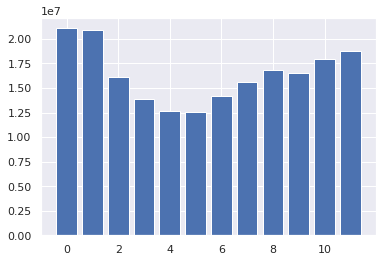

In [221]:
plt.bar(range(12), df.groupby('month')[TARGET_COLUMN].sum())

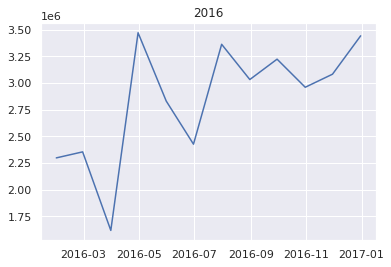

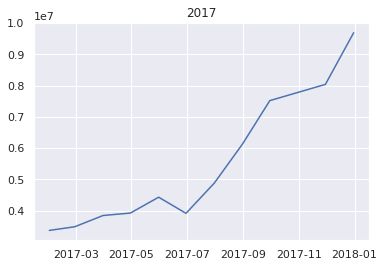

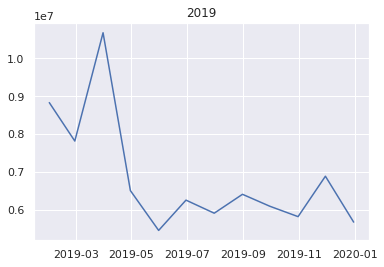

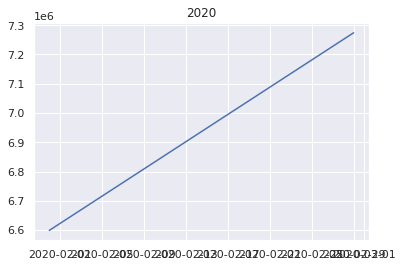

In [224]:
for year in df['year'].value_counts().index:
    fig = plt.figure()
    plt.title(f'{year}')
    plt.plot(df[df['year'] == year].groupby('date')[TARGET_COLUMN].sum())

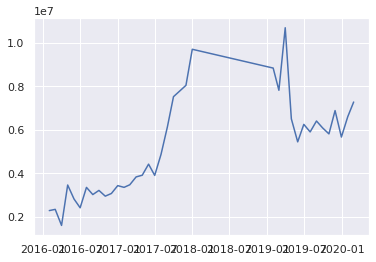

In [203]:
plt.plot(df.groupby('date')[TARGET_COLUMN].sum())

Random client history

(24,)


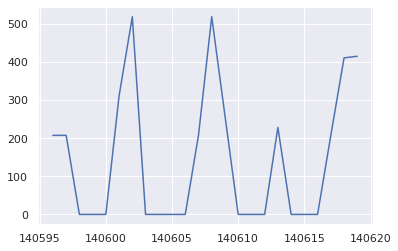

In [209]:
random_id = random.randint(0, df['id'].value_counts().shape[0])

print(df[df['id'] == random_id][TARGET_COLUMN].shape)
plt.plot(df[df['id'] == random_id][TARGET_COLUMN])

many clients does never overpay, can we detect them?

In [211]:
df.groupby('id')[TARGET_COLUMN].sum().value_counts()

0.00         1436
20740.00       73
10370.00       63
31110.00       46
51850.00       46
             ... 
137921.00       1
3009.38         1
52768.70        1
34649.50        1
81314.21        1
Name: prepaid_amount, Length: 3010, dtype: int64

Only 2 clients paid the whole loan

In [212]:
df[df['years_to_matur'] == 0]

,date,date_str,id,years_to_matur,age_owner_years,original_matur_years,client_rate,original_volume,age_loan_years,outstanding_volume,...,NUMBER_OF_FAMILY_MEMBERS,RESIDENTAL_STATUS,MARITAL_STATUS,FIXED_MONTHLY_EXPENSES,Flat_House,OPEN_DATE,INCOME_houshold,dpd,month,year
87009,2020-01-31,20200131,524,0.0,51.59,10.05,0.0626,62220.0,10.05,0.0,...,0.0,NaN,NaN,0.0,NaN,2010-04-21,0.0,1.0,1,2020
119857,2019-05-31,20190531,3106,0.0,52.34,5.00,0.0562,82960.0,5.00,0.0,...,0.0,NaN,NaN,0.0,H,2019-12-01,0.0,0.0,5,2019


In [213]:
loans = df['type'].value_counts().index

Firstly we will look separately at two types of loans

In [214]:
loans_dfs = [df[df['type'] == l] for l in loans]

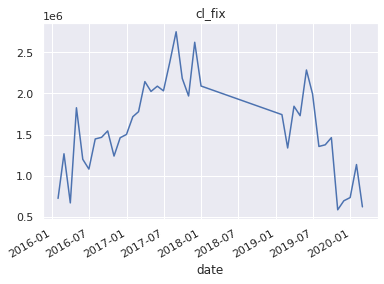

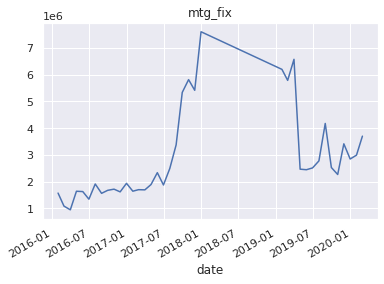

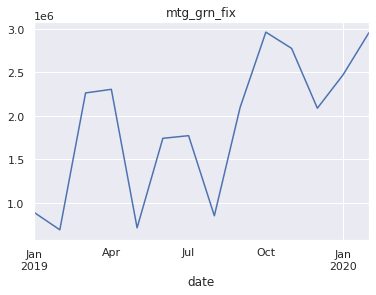

In [220]:
for i, loan_df in enumerate(loans_dfs):
    fig = plt.figure()
    plt.title(f'{loans[i]}')
    loan_df.groupby('date').sum()[TARGET_COLUMN].plot()

Next we will look at all static cat variables

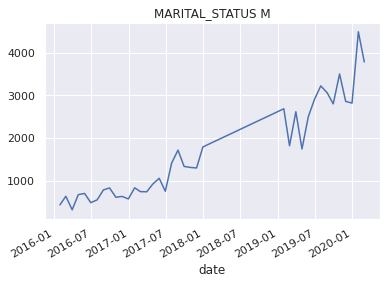

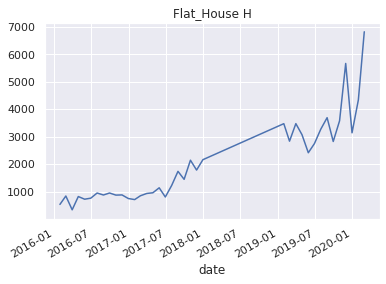

In [218]:

 static_values = ['EDUCATION',
 'RESIDENTAL_STATUS',
 'MARITAL_STATUS',
 'Flat_House']


for col in static_values:
    for val in df[col].value_counts().index:
        tmp_df = df[df[col] == val]
        if tmp_df.shape[0] > 40000:
            fig = plt.figure()
            plt.title(f'{col} {val}')
            tmp_df.groupby('date').mean()[TARGET_COLUMN].plot()

Clients change over time

<AxesSubplot:xlabel='date'>

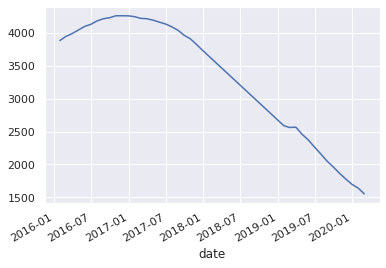

In [219]:
df.groupby(['date'])['id'].apply(len).plot()

Very important fact is that the data end at jenuary 2020 so before the covid-19 epidemix!, It will probably affects our models, If we had macroeconomic exogenus values for 2020 year we would use them.